In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1> Sentiment and Emotional Analysis of Indian Union Budget 2022-23 on Social Media</h1>

<h4>Submitted By Group-24
<ul><li>Aditya Dixit(MT21004)</li>
<li>Mohnish Basarkar(MT21052)</li>
<li>Shivang Kanwar(MT21084)</li>
<li>Shubham Aggarwal(MT21090)</li></ul></h4>

In [2]:
#importing header files 
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve,auc,f1_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


<h2> Pre-Processing of Data </h2>

In [3]:
######################## PREPROCCESSING TWEETS TO CLEAN THEM ###################
def preprocessing(t):
    #Replacing @username of users with empty string
    t = re.sub('@[^\s]+','',t)  
    #Removing repeating words like shivanggggggggg from tweets
    repeat_word = re.compile(r"(.)\1{1,}", re.IGNORECASE)
    t = repeat_word.sub(r"\1\1", t)
    #Replacing hashtag #word with only word
    t = re.sub(r'#([^\s]+)', r'\1', t)
    #Replacing all urls of the form www.* or https?://* with empty string
    t = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',t)
    #trimming tweet
    t = t.strip('\'"')
    #Both postive and negative emoticons is stored in emoticons list
    emoticons = \
    [
     ('__positive__',[ ':-)', ':)', '(:', '(-:', \
                       ':-D', ':D', 'X-D', 'XD', 'xD', \
                       '<3', ':\*', ';-)', ';)', ';-D', ';D', '(;', '(-;', ] ),\
     ('__negative__', [':-(', ':(', '(:', '(-:', ':,(',\
                       ':\'(', ':"(', ':((', ] ),\
    ]

    def joining(a):
        return '(' + '|'.join( a ) + ')'

    def change_parentheses(a):            #changing parenthesis
        return [i.replace(')', '[)}\]]').replace('(', '[({\[]') for i in a]

    emoticons_rgex = [ (i, re.compile(joining(change_parentheses(j))) ) \
            for (i, j) in emoticons ]
    
    for (i, j) in emoticons_rgex :
        t = re.sub(j, ' '+i+' ', t)
    #converting tweet to lowercase
    t = t.lower()
    return t

#stemming of tweets
def stemm(t):
        stemmer = nltk.stem.PorterStemmer()    
        stem_tweet = ''
        words = [word if(word[0:2]=='__') else word.lower() \
                    for word in t.split() \
                    if len(word) >= 3]
        words = [stemmer.stem(w) for w in words] 
        stem_tweet = ' '.join(words)
        return stem_tweet

# main function which calls preprocessing function
def mainprocess(A):
        A = [stemm(preprocessing(t)) for t in A]
        return A

In [4]:
#function containing if else case to change predicted values with emotions
def number_to_emotion(y_pred_value):
    for i in range(len(y_pred_value)):
        if (y_pred_value[i]=='0'):
            y_pred_value[i]='neutral'
        elif(y_pred_value[i]=='1'):
            y_pred_value[i]='joy'
        elif(y_pred_value[i]=='2'):
            y_pred_value[i]='sadness'
        elif(y_pred_value[i]=='3'):
            y_pred_value[i]='fear'
        elif(y_pred_value[i]=='4'):
            y_pred_value[i]='surprise'
        elif(y_pred_value[i]=='5'):
            y_pred_value[i]='anger'
        elif(y_pred_value[i]=='6'):
            y_pred_value[i]='shame'
        else:
            y_pred_value[i]='disgust'
    return y_pred_value        

In [5]:
#function to find words frequency
def dict_words(tweet,stitle):
  count_vec = CountVectorizer(stop_words = 'english')  #initializing countVectorizer
  diff_words = count_vec.fit_transform(tweet)          #finding diffrent words
  words_sum = diff_words.sum(axis=0)                   #total number of  diffrent words
  words_frequency = [(w, words_sum[0, x]) for w, x in count_vec.vocabulary_.items()] #finding frequency of words
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse = True)  #sorting
  freq = pd.DataFrame(words_frequency, columns=['Type of words', 'frequency'])   #creating a dataframe which stores words and their frequency
  freq.head(30).plot(x='Type of words', y='frequency', kind='bar', figsize=(15, 7), color = 'blue')  #plotting bar graph
  plt.title(stitle)
  return words_frequency #returning frequency

In [6]:
#function which predict the emotions of tweets and reports it's accuracy
def emotion_analysis(model , test_vector , y_true, accuracy_str, figname, stitle, classifiername):
    y_pred_value = model.predict(test_vector)
    y_predicted = y_pred_value
    accu = accuracy_score(y_pred_value , y_true)
    print(accuracy_str + " : "+ str(accu))               #print accuracy achieved through the model provided
    print("Classification Report for "+ classifiername)
    print(classification_report(y_pred_value,y_true))     #print various parameters in classification report
    y_pred_value = y_pred_value.tolist()
    y_pred_value = number_to_emotion(y_pred_value)
    emotions_count = []
    for emotions in list_emotions:
        emotions_count.append(y_pred_value.count(emotions))
    d = pd.DataFrame({'Various Emotions': list(list_emotions), 'Count of Tweets': list(emotions_count)})
    fig = plt.figure(figsize=(6,6))                                             #plotting of graph is done
    ax = sns.barplot(data=d, x= "Various Emotions", y = "Count of Tweets")
    ax.set(ylabel = 'Count of Tweets')
    ax.set(title = stitle)
    plt.savefig (figname,bbox_inches="tight",pad_inches=2)
    plt.show()  
    return y_predicted

In [7]:
#function for testing diffrent model accuracy
def test_model_accuracy(test_tweet,train_tweet,splitratio,modelchoose,accuracy_str, figname, stitle, classifiername,model_name):
  x_train , x_test , y_train , y_test = train_test_split(test_tweet, train_tweet, test_size= splitratio, random_state=42)
  test_vectors = tfidf_vect.transform(x_test)  #vectors for test data
  train_vectors = tfidf_vect.transform(x_train) #vectors for train data
  if modelchoose == 0:              #using if else to choose model and finding accuracy
    model = MultinomialNB()
  elif modelchoose == 1:
    model = KNeighborsClassifier()
  elif modelchoose == 2:
    model = XGBClassifier()    
  model.fit(train_vectors, y_train)   #fitting data on model
  pickle.dump(model, open(model_name, 'wb'))
  loaded_model = pickle.load(open(model_name, 'rb'))
  y_pred_true = emotion_analysis(model ,test_vectors,y_test,accuracy_str, figname, stitle, classifiername)


<h2>Pre-Labeled Data classified into emotions</h2>

In [8]:
# we used prelabeled data to train our model and classify data into different labels
data_train = pd.read_csv("/content/drive/My Drive/IR_project_midsem/emotion_dataset_raw.csv")
data_train.head()

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


In [9]:
#printing all the unique emotions
data_train['Emotion'].unique()

array(['neutral', 'joy', 'sadness', 'fear', 'surprise', 'anger', 'shame',
       'disgust'], dtype=object)

In [10]:
x_train = data_train['Text']     #taking emotions and x_train
x_train = mainprocess(x_train)   #preprocessing tweets
y_train = data_train['Emotion']  #taking emotions and storing in y_train
y_train = y_train.replace(['neutral', 'joy', 'sadness', 'fear', 'surprise', 'anger', 'shame',   #replacing emotion classes with numbers
       'disgust'],['0','1','2','3','4','5','6','7'])

In [11]:
tfidf_vect = TfidfVectorizer(min_df=3, max_df=0.9)  
train_vectors = tfidf_vect.fit_transform(x_train)  #creating vector of training data using TfidfVectorizer
model = RandomForestClassifier()  
model.fit(train_vectors, y_train)

RandomForestClassifier()

In [12]:
list_emotions = ['neutral', 'joy', 'sadness', 'fear', 'surprise', 'anger', 'shame','disgust'] #list of emotions
def process_data(readfile,modelname,stitle,figname):
    data = pd.read_csv(readfile)
    x_test = data["Tweet Content"]
    x_test = mainprocess(x_test)
    test_vectors = tfidf_vect.transform(x_test)
    filename = modelname
    pickle.dump(model, open(filename, 'wb'))
    loaded_model = pickle.load(open(filename, 'rb'))
    y_pred_value = model.predict(test_vectors)
    y_predicted = y_pred_value
    y_pred_value = y_pred_value.tolist()
    y_pred_value = number_to_emotion(y_pred_value)
    emotions_count = []
    for emotions in list_emotions:
        emotions_count.append(y_pred_value.count(emotions))
    d = pd.DataFrame({'Various Emotions': list(list_emotions), 'Count of Tweets': list(emotions_count)})  #storing emotions and tweets count in dataframe
    fig = plt.figure(figsize=(6,6))
    ax = sns.barplot(data=d, x= "Various Emotions", y = "Count of Tweets")
    ax.set(ylabel = 'Count of Tweets') 
    ax.set(title = stitle)
    plt.savefig(figname,bbox_inches="tight",pad_inches=2)
    return data,x_test, y_predicted

In [13]:
#using the Sentiment Intensity Analyzer object with vader sentiment analyzer
def discover_sentiment(df,stitle,figname):
    sia = SentimentIntensityAnalyzer() #sentimentintensityAnalyzer object
    pos,neg=0,0
    list_y = []
    #calculating the polarity score of all the tweets
    for ind, row in df.iterrows():
        s = sia.polarity_scores(row["Tweets"])
        if s['compound'] >= 0.0 : 
            pos+=1 
            score=1
        else: 
            neg+=1
            score=0
        g=[s,score]
        list_y.append(g)
    sentiment_scores={"Positive":pos,"Negative":neg}
    se = pd.DataFrame(list_y,columns=["polarity","lexicon label"])
    df=pd.concat([df, se], axis=1)
    d = pd.DataFrame({'Sentiment values': list(sentiment_scores.keys()), 'Count of Tweets': list(sentiment_scores.values())})
    fig = plt.figure(figsize=(6,6))
    ax = sns.barplot(data=d, x= "Sentiment values", y = "Count of Tweets")
    ax.set(ylabel = 'Count of Tweets')
    ax.set(title = stitle)
    plt.savefig(figname,bbox_inches="tight",pad_inches=2)
    plt.show()

In [14]:
#function for generating wordcloud
def make_wordcloud(tweets,sColor,stitle,stitle1,figname):
  wc = WordCloud(background_color = sColor, width = 1000, height = 1000).generate_from_frequencies(dict(dict_words(tweets,stitle)))
  plt.figure(figsize=(10,8))
  plt.imshow(wc)
  plt.title(stitle1, fontsize = 22)
  plt.savefig(figname)

<h2>1. Pre-Budget Phase 2022-23 tweets</h2>

<h3> 1.1 Sentiment Analysis</h3>

In [15]:
# downloading vader_lexicon for doing sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

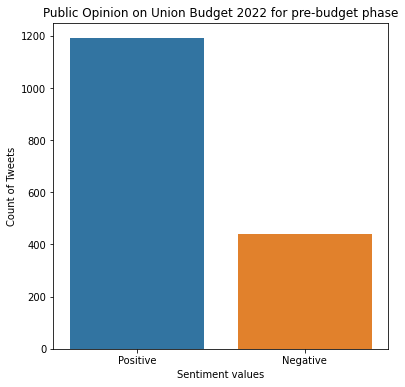

In [16]:
#taking tweets of before budget and storing into dataframe
data_csv = pd.read_csv("/content/drive/My Drive/IR_project_midsem/before_budget.csv")
data_df = pd.DataFrame()
data_df['Tweets'] = data_csv['Tweet Content'].copy()
#finding sentiment of tweets and showing them as bar graph
discover_sentiment(data_df,"Public Opinion on Union Budget 2022 for pre-budget phase","prephase_sentiment.jpg")

<h3> 1.2 Emotional Analysis</h3>

,Unnamed: 0,Tweet Id,Datetime,Username,Tweet Content,Retweet Count,Reply Count,Like Count,Clean Tweets
0,0,1487884165383168007,2022-01-30 20:23:23+00:00,Muhammad5402,"@ABMPildat And accordingly to Income Tax laws,...",0,1,1,"and accordingli incom tax laws, case can open ..."
1,1,1487880463872327680,2022-01-30 20:08:40+00:00,ANKITVE32044051,Things are not important \nIf It just expensiv...,1,0,2,thing are not import just expens accord your b...
2,2,1487853886870278150,2022-01-30 18:23:04+00:00,backtoearth101,Inflation at peak! Petrol oil wheat flour pric...,0,0,0,inflat peak! petrol oil wheat flour price max!...
3,3,1487852557569564672,2022-01-30 18:17:47+00:00,backtoearth101,GDP growing at 5 percent? Is this the only par...,1,2,9,gdp grow percent? thi the onli paramet think c...
4,4,1487849518590984192,2022-01-30 18:05:42+00:00,bhaveshkumar44,Turkish President Recep Tayyip Erdogan has sac...,0,0,0,turkish presid recep tayyip erdogan ha sack th...


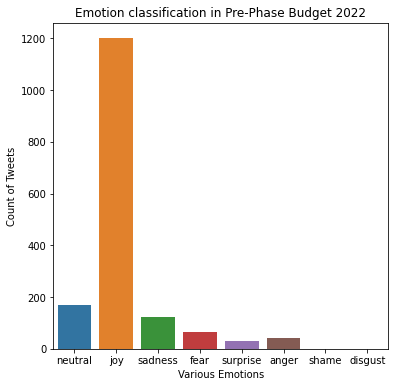

In [17]:
pre_budget_data,pre_budget_cleantweets, y_predicted_before = process_data("/content/drive/My Drive/IR_project_midsem/before_budget.csv","random_model_prePhase.sav","Emotion classification in Pre-Phase Budget 2022","Emotion_Pre-Phase.jpg")
df = pd.DataFrame(pre_budget_cleantweets,columns =['Clean Tweets'])
col = df['Clean Tweets']            
pre_budget_data = pre_budget_data.join(col) #adding clean tweets dataframe to csv containing tweets and their information
pre_budget_data.drop(['User Location', 'User Verified'], axis='columns', inplace=True)
pre_budget_data.head()

<h3> 1.3 Word cloud and frequency distribution </h3> 

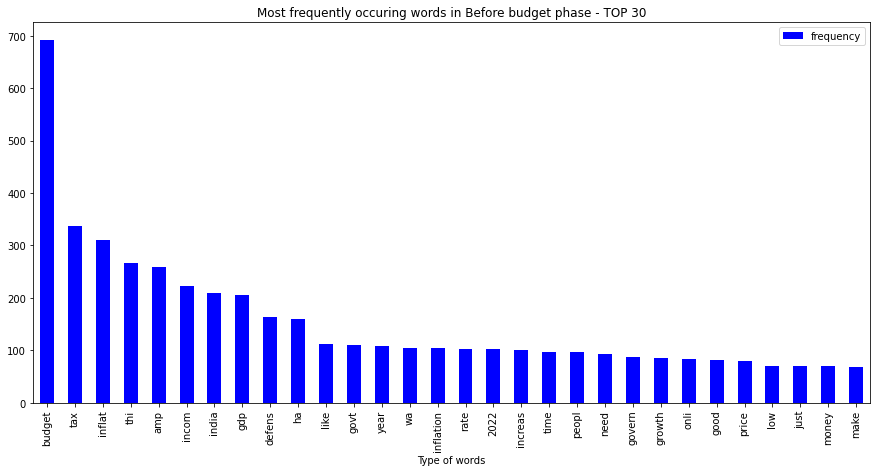

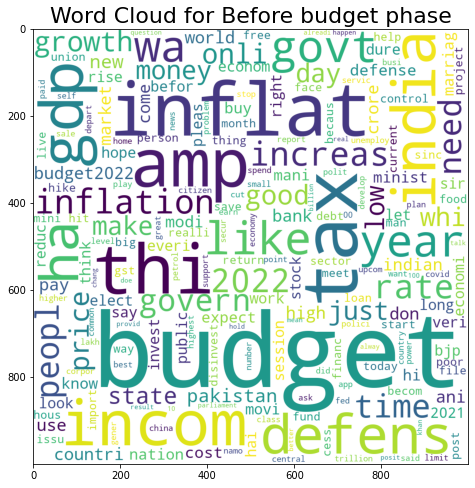

In [18]:
#top 30 occuring words and word cloud 
make_wordcloud(pre_budget_cleantweets,"white","Most frequently occuring words in Before budget phase - TOP 30","Word Cloud for Before budget phase","pre-phase_wordcloud.jpg")

<h3> 1.4  Classification through various models and finding their accuracies</h3>

Accuracy through Multinomial NB classifier during pre-phase budget 2022 : 0.7798165137614679
Classification Report for Multinomial NB classifier
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.78      0.88       327
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.78       327
   macro avg       0.17      0.13      0.15       327
weighted avg       1.00      0.78      0.88       327



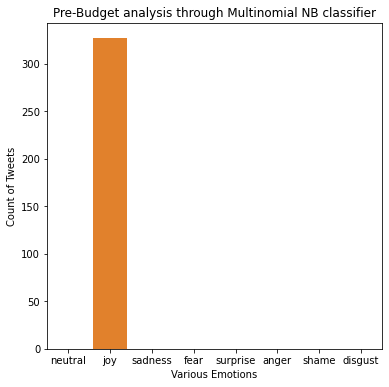

In [19]:
#finding accuracy of Multinomial NB classifier for pre-budget annoucement tweets
test_model_accuracy(pre_budget_cleantweets,y_predicted_before, 0.2, 0,"Accuracy through Multinomial NB classifier during pre-phase budget 2022", "prephase_mnb.jpg", "Pre-Budget analysis through Multinomial NB classifier", "Multinomial NB classifier" , "multiNB_pre.sav")

Accuracy through XGB classifier during pre-phase budget 2022 : 0.8318042813455657
Classification Report for XGB classifier
              precision    recall  f1-score   support

           0       0.88      0.63      0.73        35
           1       0.94      0.87      0.90       275
           2       0.19      0.50      0.27        12
           3       0.40      1.00      0.57         2
           4       0.75      1.00      0.86         3
           5       0.00      0.00      0.00         0

    accuracy                           0.83       327
   macro avg       0.53      0.67      0.56       327
weighted avg       0.90      0.83      0.86       327



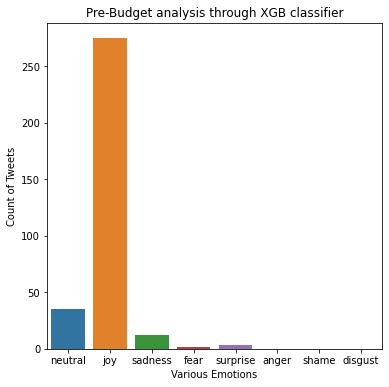

In [20]:
#finding accuracy of XGB classifier for pre-budget annoucement tweets
test_model_accuracy(pre_budget_cleantweets,y_predicted_before, 0.2, 2,"Accuracy through XGB classifier during pre-phase budget 2022", "prephase_XGB.jpg", "Pre-Budget analysis through XGB classifier", "XGB classifier","xgb_pre.sav" )

<h2> 2. Post-Budget Phase 2022-23 tweets</h2>

<h3>2.1 Sentiment Analysis</h3>

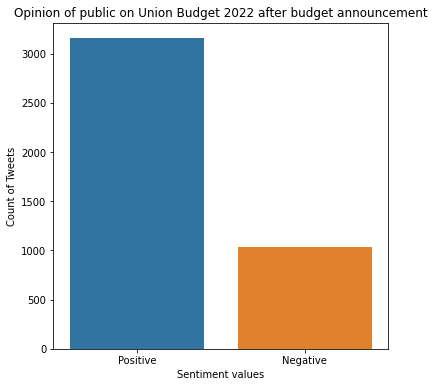

In [22]:
#taking before budget tweets and storing them into dataframe
data_csv1 = pd.read_csv("/content/drive/My Drive/IR_project_midsem/after_budget.csv")
data_df1 = pd.DataFrame()
data_df1['Tweets'] = data_csv1['Tweet Content'].copy()
#finding sentiment of tweets and showing them as bar graph
discover_sentiment(data_df1,"Opinion of public on Union Budget 2022 after budget announcement","postphase_sentiment.jpg")

<h3>2.2 Emotional Analysis</h3>

,Unnamed: 0,Tweet Id,Datetime,Username,Tweet Content,Retweet Count,Reply Count,Like Count,Clean Tweets
0,0,1498082036367912961,2022-02-27 23:46:05+00:00,Putera_Ns,Rolls Royce of defense. Simply awesome https:/...,0,1,1,roll royc defense. simpli awesom
1,1,1498057990557024261,2022-02-27 22:10:32+00:00,pleasehesitate1,@AzizkhanISF 🤦🤦 be like a defense minister.,0,1,0,like defens minister.
2,2,1498026236177641473,2022-02-27 20:04:21+00:00,fincase_in,You need someone who tells you that -\n'You do...,0,0,0,you need someon who tell you that 'you don't n...
3,3,1498019574419132416,2022-02-27 19:37:53+00:00,colour135,The extent to which small countries are vulner...,0,0,0,the extent which small countri are vulner stro...
4,4,1498017907674329089,2022-02-27 19:31:15+00:00,NasrinRasheda,Russian President #Putin orders his defense ch...,2,1,3,russian presid putin order hi defens chief put...


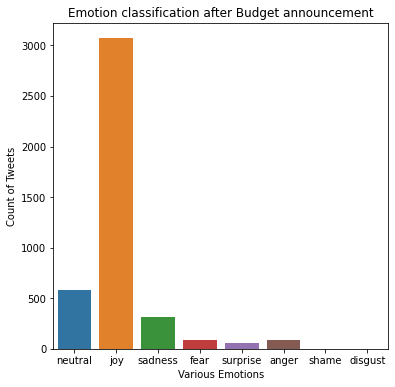

In [23]:
#Creating dataframe containing clean tweets and tweets data
post_budget_data,post_budget_cleantweets, y_predicted_after = process_data("/content/drive/My Drive/IR_project_midsem/after_budget.csv","random_model_postPhase.sav","Emotion classification after Budget announcement","Emotion_Post-Phase.jpg")
df1 = pd.DataFrame(post_budget_cleantweets,columns =['Clean Tweets'])
e1 = df1['Clean Tweets']          
post_budget_data = post_budget_data.join(e1) #adding clean tweets column to csv containing tweets and their information
post_budget_data.drop(['User Location', 'User Verified'], axis='columns', inplace=True)
post_budget_data.head()

<h3> 2.3 Word cloud and frequency distribution </h3> 


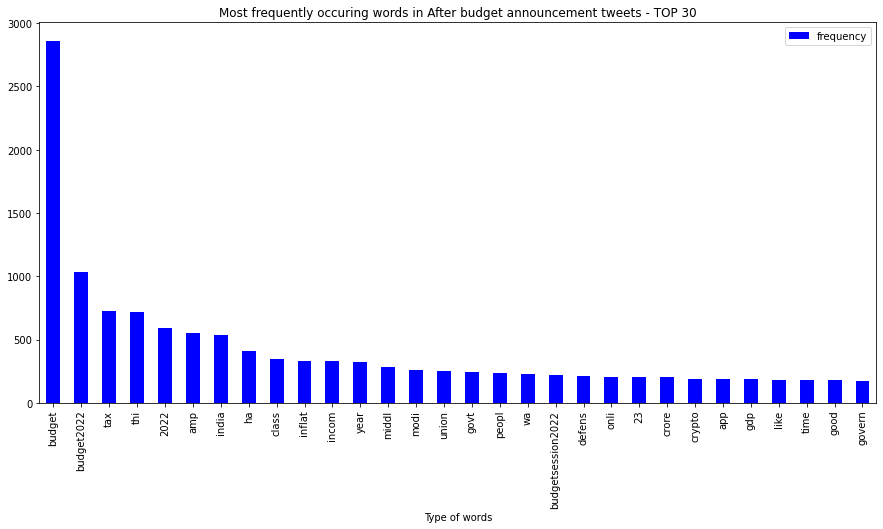

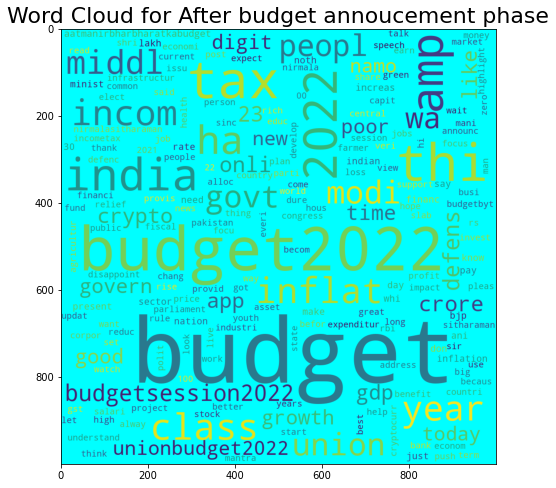

In [24]:
#top 30 occuring words and word cloud
make_wordcloud(post_budget_cleantweets,"cyan","Most frequently occuring words in After budget announcement tweets - TOP 30","Word Cloud for After budget annoucement phase"," post-phase_wordcloud.jpg")

<h3> 2.4  Classification through various models and finding their accuracies</h3>

Accuracy through Multinomial NB classifier during post-phase budget 2022 : 0.735399284862932
Classification Report for Multinomial NB classifier
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.74      0.85       839
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.74       839
   macro avg       0.14      0.11      0.12       839
weighted avg       1.00      0.74      0.85       839



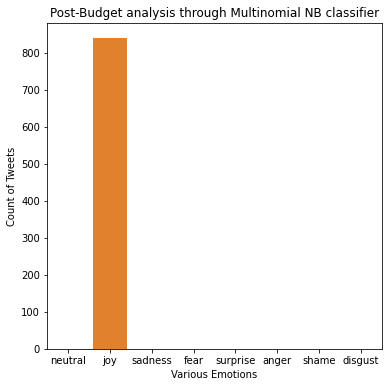

In [25]:
#Finding Accuracy for MultinomialNB classifier for post-budget tweets
test_model_accuracy(post_budget_cleantweets,y_predicted_after, 0.2, 0,"Accuracy through Multinomial NB classifier during post-phase budget 2022", "postphase_mnb.jpg", "Post-Budget analysis through Multinomial NB classifier", "Multinomial NB classifier" ,"multiNB_post.sav")

Accuracy through XGB classifier during post-phase budget 2022 : 0.8700834326579261
Classification Report for XGB classifier
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       133
           1       0.97      0.90      0.93       665
           2       0.41      0.73      0.52        33
           3       0.25      1.00      0.40         5
           4       0.20      0.67      0.31         3
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.87       839
   macro avg       0.39      0.58      0.43       839
weighted avg       0.93      0.87      0.89       839



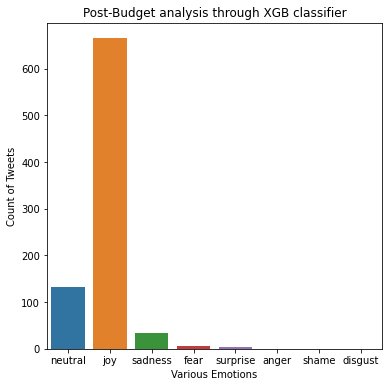

In [26]:
#Finding Accuracy for XGB classifier for post-budget tweets
test_model_accuracy(post_budget_cleantweets,y_predicted_after, 0.2, 2,"Accuracy through XGB classifier during post-phase budget 2022", "postphase_XGB.jpg", "Post-Budget analysis through XGB classifier", "XGB classifier","xgb_post.sav" )